## pytorch -> caffe2模型的转换

In [66]:
import re

import onnx
import torch
from torch.autograd import Variable
from onnx import onnx_pb
from model.DHS_vgg import Vgg
import numpy as np

import caffe2.python.onnx.backend as onnx_caffe2_backend
# Now import the caffe2 mobile exporter
from caffe2.python.predictor import mobile_exporter
%matplotlib inline

## pytorch -> onnx

In [67]:
IMG_SIZE = 224

TMP_ONNX = 'cache/onnx/DHSNet.onnx'
MODEL_PATH = 'cache/opti/total-opti-current.pth'

# Convert to ONNX once
model = torch.load(MODEL_PATH).cuda()
model.train(False)

x = Variable(torch.randn(1, 3, 224, 224), requires_grad=True).cuda()
torch_out = torch.onnx._export(model, x, TMP_ONNX, export_params=True)

## onnx -> caffe2

In [68]:
# Print out ONNX model to confirm the number of output layer
onnx_model = onnx.load(TMP_ONNX)
# print(onnx_model)
# Check that the IR is well formed
onnx.checker.check_model(onnx_model)
# Print a human readable representation of the graph
# print(onnx.helper.printable_graph(onnx_model.graph))

# prepare the caffe2 backend for executing the model this converts the ONNX model into a
# Caffe2 NetDef that can execute it. Other ONNX backends, like one for CNTK will be
# availiable soon.
prepared_backend = onnx_caffe2_backend.prepare(onnx_model)

# run the model in Caffe2

# Construct a map from input names to Tensor data.
# The graph of the model itself contains inputs for all weight parameters, after the input image.
# Since the weights are already embedded, we just need to pass the input image.
# Set the first input.
W = {onnx_model.graph.input[0].name: x.cpu().data.numpy()}

# Run the Caffe2 net:
c2_out = prepared_backend.run(W)[4]

print(torch_out[4].cpu().detach().numpy().shape)
# Verify the numerical correctness upto 3 decimal places
np.testing.assert_almost_equal(torch_out[4].cpu().detach().numpy(), c2_out, decimal=3)

print("Exported model has been executed on Caffe2 backend, and the result looks good!")

(1, 1, 224, 224)
Exported model has been executed on Caffe2 backend, and the result looks good!


In [69]:
# extract the workspace and the model proto from the internal representation
c2_workspace = prepared_backend.workspace
c2_model = prepared_backend.predict_net

# call the Export to get the predict_net, init_net. These nets are needed for running things on mobile
init_net, predict_net = mobile_exporter.Export(c2_workspace, c2_model, c2_model.external_input)

# Let's also save the init_net and predict_net to a file that we will later use for running them on mobile
with open('./cache/model_mobile/init_net.pb', "wb") as fopen:
    fopen.write(init_net.SerializeToString())
with open('./cache/model_mobile/predict_net.pb', "wb") as fopen:
    fopen.write(predict_net.SerializeToString())

print("over...")

over...


## 对纯caffe2后端的网络进行测试

In [70]:
# Some standard imports
from caffe2.proto import caffe2_pb2
from caffe2.python import core, net_drawer, net_printer, visualize, workspace, utils

import numpy as np
import os
import subprocess
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, transform

In [71]:
# load the image
img_in = io.imread("./data/DUTS/train/images/ILSVRC2012_test_00000004.jpg")

# resize the image to dimensions 224x224
img = transform.resize(img_in, [224, 224])

# save this resized image to be used as input to the model
io.imsave("./data/ILSVRC2012_test_00000004_224x224.jpg", img)

/home/lart/.conda/envs/pt/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/lart/.conda/envs/pt/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/lart/.conda/envs/pt/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [72]:
# load the resized image and convert it to Ybr format
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = Image.open("./data/ILSVRC2012_test_00000004_224x224.jpg")
img = np.array(img)
img = img.astype(np.float64) / 255
img -= mean
img /= std
img = img.transpose(2, 0, 1)

In [73]:
# Let's run the mobile nets that we generated above so that caffe2 workspace is properly initialized
workspace.RunNetOnce(init_net)
workspace.RunNetOnce(predict_net)

# Caffe2 has a nice net_printer to be able to inspect what the net looks like and identify
# what our input and output blob names are.
print(net_printer.to_string(predict_net))

model_input_blob = predict_net.external_input[0]
model_output_blob = predict_net.external_output[-1]
print('Input blob: ', model_input_blob)
print('Output blob: ', model_output_blob)

torch-jit-export_predict = core.Net('torch-jit-export_predict')
torch-jit-export_predict.Conv(['0', '1', '2'], ['152'], strides=[1, 1], pads=[1, 1, 1, 1], kernels=[3, 3], group=1, dilations=[1, 1])
torch-jit-export_predict.SpatialBN(['152', '3', '4', '5', '6'], ['153'], momentum=1.0, epsilon=9.999999747378752e-06, is_test=1)
torch-jit-export_predict.Relu(['153'], ['154'])
torch-jit-export_predict.Conv(['154', '8', '9'], ['155'], strides=[1, 1], pads=[1, 1, 1, 1], kernels=[3, 3], group=1, dilations=[1, 1])
torch-jit-export_predict.SpatialBN(['155', '10', '11', '12', '13'], ['156'], momentum=1.0, epsilon=9.999999747378752e-06, is_test=1)
torch-jit-export_predict.Relu(['156'], ['157'])
torch-jit-export_predict.MaxPool(['157'], ['158'], strides=[2, 2], pads=[0, 0, 0, 0], kernels=[2, 2])
torch-jit-export_predict.Conv(['158', '15', '16'], ['159'], strides=[1, 1], pads=[1, 1, 1, 1], kernels=[3, 3], group=1, dilations=[1, 1])
torch-jit-export_predict.SpatialBN(['159', '17', '18', '19', '20'], 

In [74]:
# Now, let's also pass in the resized cat image for processing by the model.
workspace.FeedBlob(model_input_blob, np.array(img)[np.newaxis, :, :, :].astype(np.float32))

# run the predict_net to get the model output
workspace.RunNetOnce(predict_net)

# Now let's get the model output blob
img_out = workspace.FetchBlob(model_output_blob)

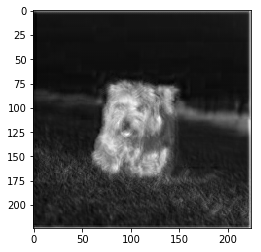

In [75]:
plt.imshow(img_out[0, 0], cmap='gray')